#Import các thư viện cần thiết

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from statistics import mean

#Kiểm tra xem chúng ta có thể sử dụng ``torch.cuda`` hay không

* Mặc định sẽ sử dụng CPU nếu không thể sử dụng CUDA (hiểu một cách đơn giản - nhưng có thể không đúng - là chỗ này đang quyết định nên dùng CPU hay GPU)
* Để sử dụng được ``torch.cuda`` thì phải chỉnh loại thời gian chạy (runtime) trên Colab thành GPU

* Nên sử dụng GPU nếu có thể



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


#Cài đặt lớp ``NeuralNetwork ``
*(a.k.a quyết định cấu trúc của NNs - số layers, số neurons, hàm activation,...)*


* Không giống như sklearn đối với Pytorch chúng ta không thể cứ import một module rồi cứ truyền tham số vào sử dụng
* Phải cài đặt một lớp mới kế thừa ``nn.Module``
* Cấu trúc của NN được lưu tại các thuộc tính (data attributes)
* Cần định nghĩa phương thức (method) cho Feedforward (``forward``) - nói cách khác ``forward`` cài đặt các phép tính sẽ được thực hiện trên input

Xem thêm về [OOP trong Python](https://www.youtube.com/watch?v=-DP1i2ZU9gk&t=160s)



In [ ]:
from torch.nn.modules.activation import ReLU
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(),
            nn.Linear(28*28, 512), 
            nn.Dropout(),                     
            nn.ReLU(),   
            nn.Linear(512,512),
            nn.Dropout(),
            nn.ReLU(),                                                                          
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

#Định nghĩa ``train_loop``
* Quyết định quá trình training sẽ được thực hiện như thế nào
* Lưu ý chuyển data qua cùng ``device`` với model (nếu không sẽ xuất hiện ``RuntimeError``)
* ``model`` dự đoán dựa trên input
* ``optimizer.zero_grad`` đưa gradient trở về giá trị 0
* ``loss.backward`` thực hiện backpropagation
* ``optimizer`` thực hiện thay đổi trên weights và bias


In [ ]:
train_loss = []
test_loss_glb = []

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    
    avg_loss = []
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

        avg_loss.append(loss.item())

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss.append(mean(avg_loss))
        

#Định nghĩa test_loop
*(hàm này sẽ cho biết độ chính xác của model)*

In [ ]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_loss_glb.append(test_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#Load data


* Dataset được sử dụng là KMNIST ([Kuzushiji-MNIST](https://github.com/rois-codh/kmnist))
* Gồm 70,000 ảnh 28x28
* Dataset có 10 classes thể hiện cho các ký tự trong bảng chữ cái Hiragana
* Các classes trong dataset đã được encode từ 0 đến 9

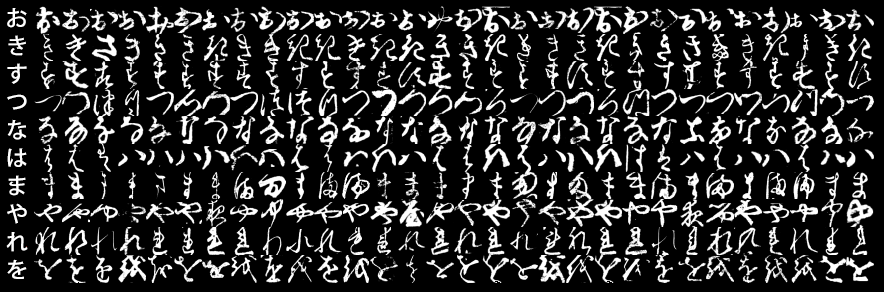



In [ ]:
training_data = datasets.KMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.KMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()    
)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

#Một số samples trong dataset


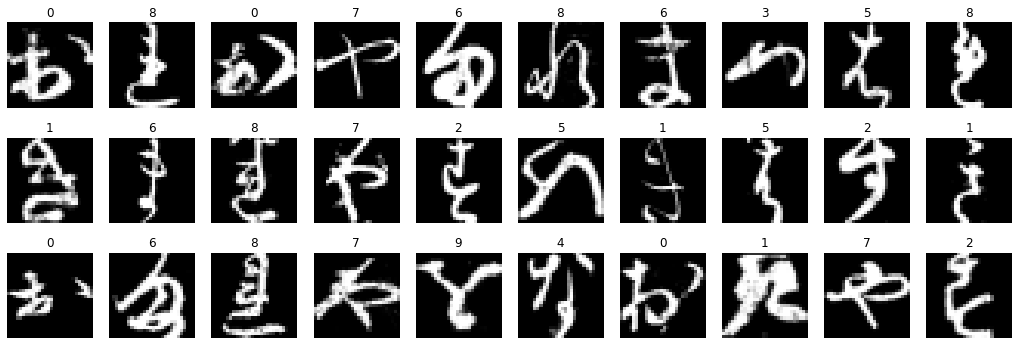

In [ ]:
figure = plt.figure(figsize=(18, 6))
cols, rows = 10,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#Kiểm tra cấu trúc của model và chuyển model qua ``device`` đang sử dụng

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)


#Thiết lập giá trị cho các hyperparameters

In [ ]:
learning_rate = 0.1
batch_size = 64
epochs = 10

#Train và test model
* Hàm loss được sử dụng là Cross Entropy
* ``optimizer`` được sử dụng là Stochastic Gradient Descent (``SGD``)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.290022  [    0/60000]
loss: 1.481775  [ 6400/60000]
loss: 1.333643  [12800/60000]
loss: 0.810178  [19200/60000]
loss: 0.556375  [25600/60000]
loss: 0.807493  [32000/60000]
loss: 0.725532  [38400/60000]
loss: 0.804796  [44800/60000]
loss: 0.493966  [51200/60000]
loss: 0.525994  [57600/60000]
Test Error: 
 Accuracy: 67.0%, Avg loss: 1.037289 

Epoch 2
-------------------------------
loss: 0.693901  [    0/60000]
loss: 0.589903  [ 6400/60000]
loss: 0.693879  [12800/60000]
loss: 0.599669  [19200/60000]
loss: 0.268524  [25600/60000]
loss: 0.462642  [32000/60000]
loss: 0.577323  [38400/60000]
loss: 0.586147  [44800/60000]
loss: 0.211556  [51200/60000]
loss: 0.605775  [57600/60000]
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.855647 

Epoch 3
-------------------------------
loss: 0.580470  [    0/60000]
loss: 0.506338  [ 6400/60000]
loss: 0.472793  [12800/60000]
loss: 0.333545  [19200/60000]
loss: 0.338030  [25600/60000]
loss: 0.537424  [32000/600

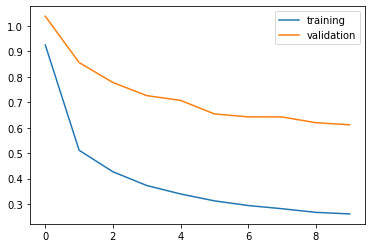

In [ ]:
plt.plot(range(epochs), train_loss, label="training")
plt.plot(range(epochs),test_loss_glb, label="validation")
plt.legend()
plt.show()